In [1]:
import os
import re
import numpy as np
import networkx as nx
from collections import Counter

In [2]:
import scipy.sparse as sp
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd

In [3]:
## Standard libraries
import os
import json
import math
import numpy as np 
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# # Torchvision
# import torchvision
# from torchvision.datasets import CIFAR10
# from torchvision import transforms

In [48]:
class GCNLayer(nn.Module):
    
    def __init__(self, c_in, c_out):
        super().__init__()
        self.projection = nn.Linear(c_in, c_out)

    def forward(self, node_feats, adj_matrix):
        """
        Inputs:
            node_feats - Tensor with node features of shape [batch_size, num_nodes, c_in]
            adj_matrix - Batch of adjacency matrices of the graph. If there is an edge from i to j, adj_matrix[b,i,j]=1 else 0.
                         Supports directed edges by non-symmetric matrices. Assumes to already have added the identity connections. 
                         Shape: [batch_size, num_nodes, num_nodes]
        """
        # Num neighbours = number of incoming edges
        num_neighbours = adj_matrix.sum(dim=-1, keepdims=True) #sum along rows = 1, along cols = 0
        # if(num_neighbours == 0):
        #     num_neighbours = 1
        node_feats = self.projection(node_feats)
        node_feats = torch.bmm(adj_matrix, node_feats)
        # node_feats = node_feats / num_neighbours
        node_feats = torch.div(node_feats, num_neighbours)
        node_feats = torch.nan_to_num(node_feats, nan=0.0)
        # print(node_feats)
        return node_feats

In [83]:
def normalize_adj(adj, self_loop=True):
    """Symmetrically normalize adjacency matrix."""
    if self_loop:
        adj = adj + sp.eye(adj.shape[0])
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()



def download(dataset):
    print("in download")
    basedir = os.path.dirname(os.path.abspath(''))
    print("basedir in download", basedir)
    datadir = os.path.join(basedir, 'jaynee', 'data', dataset)
    print("datadir in download", datadir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)
        url = 'https://ls11-www.cs.tu-dortmund.de/people/morris/graphkerneldatasets/{0}.zip'.format(dataset)
        zipfile = os.path.basename(url)
        os.system('wget {0}; unzip {1}'.format(url, zipfile))
        os.system('mv {0}/* {1}'.format(dataset, datadir))
        os.system('rm -r {0}'.format(dataset))
        os.system('rm {0}'.format(zipfile))



def process(dataset):
    print("in process")
    src = os.path.join(os.path.dirname(os.path.abspath('')), 'jaynee', 'data')
    prefix = os.path.join(src, dataset, dataset)
    print("src in process", src)
    print("prefix in process", prefix)

    graph_node_dict = {}
    #graph_node_dict-> key=node_ids , val=graph_id that node belongs to
    with open('{0}_graph_indicator.txt'.format(prefix), 'r') as f:
        #graph_indicator stores graph_id of node with node_id=i , in ith line
        for idx, line in enumerate(f):
            graph_node_dict[idx + 1] = int(line.strip('\n'))
    max_nodes = Counter(graph_node_dict.values()).most_common(1)[0][1]
    #max no of nodes that occur across all graphs in this dataset

    node_labels = []
    #list of node label for node with node_id=i in ith line
    if os.path.exists('{0}_node_labels.txt'.format(prefix)):
        with open('{0}_node_labels.txt'.format(prefix), 'r') as f:
            # ith line stores label of node with node_id i
            for line in f:
                node_labels += [int(line.strip('\n')) - 1]
            num_unique_node_labels = max(node_labels) + 1
    else:
        print('No node labels')

    node_attrs = []
    if os.path.exists('{0}_node_attributes.txt'.format(prefix)):
        with open('{0}_node_attributes.txt'.format(prefix), 'r') as f:
            for line in f:
                node_attrs.append(
                    np.array([float(attr) for attr in re.split("[,\s]+", line.strip("\s\n")) if attr], dtype=np.float)
                )
    else:
        print('No node attributes')

    graph_labels = []
    unique_labels = set()
    with open('{0}_graph_labels.txt'.format(prefix), 'r') as f:
        #ith line strores label of graph with graph_id=i
        for line in f:
            val = int(line.strip('\n'))
            if val not in unique_labels:
                unique_labels.add(val)
            graph_labels.append(val)
            #graph_labels will store N no of labels (where N is the no of graphs)
    label_idx_dict = {val: idx for idx, val in enumerate(unique_labels)}
    #label_idx_dict -> key=label itself , val =index starting from 0

    graph_labels = np.array([label_idx_dict[l] for l in graph_labels])
    #graph labels converted ro 1D array storing the index of the label for each of the N graphs


    adj_list = {idx: [] for idx in range(1, len(graph_labels) + 1)}
    #adj_list ->dict with key = graph_id, val = list of all edges in the graph
    index_graph = {idx: [] for idx in range(1, len(graph_labels) + 1)}
    #index_graph -> key = graph_id, val = list of all nodes in the graph
    with open('{0}_A.txt'.format(prefix), 'r') as f:
        for line in f:
            u, v = tuple(map(int, line.strip('\n').split(',')))
            adj_list[graph_node_dict[u]].append((u, v))
            index_graph[graph_node_dict[u]] += [u, v]

    for k in index_graph.keys():
        index_graph[k] = [u - 1 for u in set(index_graph[k])]
    #now index_graph dict has -> key=graph_id , val=list(nodes in the graph occuring only once in the list)

    graphs = []
    #list of nx_graphs
    for idx in range(1, 1 + len(adj_list)):
        graph = nx.from_edgelist(adj_list[idx])
        #creating a graph from its list of edges
        if max_nodes is not None and graph.number_of_nodes() > max_nodes:
            continue

        graph.graph['label'] = graph_labels[idx - 1]
        #assigning the label to the graph
        for u in graph.nodes():
            if len(node_labels) > 0:
                node_label_one_hot = [0] * num_unique_node_labels
                node_label = node_labels[u - 1]
                node_label_one_hot[node_label] = 1
                graph.nodes[u]['label'] = node_label_one_hot
            if len(node_attrs) > 0:
                graph.nodes[u]['feat'] = node_attrs[u - 1]
        if len(node_attrs) > 0:
            graph.graph['feat_dim'] = node_attrs[0].shape[0]

        # relabeling
        mapping = {}
        #dictionary with mapping-> key= node_index starting from 0 , val = node_id
        for node_idx, node in enumerate(graph.nodes()):
            mapping[node] = node_idx

        graphs.append(nx.relabel_nodes(graph, mapping))

    if 'feat_dim' in graphs[0].graph:
        pass
    else:
        max_deg = max([max(dict(graph.degree).values()) for graph in graphs])
        #max degree encountered across all nodes over all graphs
        for graph in graphs:
            for u in graph.nodes(data=True):
                f = np.zeros(max_deg + 1)
                f[graph.degree[u[0]]] = 1.0
                if 'label' in u[1]:
                    f = np.concatenate((np.array(u[1]['label'], dtype=np.float), f))
                graph.nodes[u[0]]['feat'] = f
                #so the node features in every graph have incorporated the deg of the node & node label(if there is any)
    return graphs
  






def load(dataset):
    basedir = os.path.dirname(os.path.abspath(''))
    print("basedir inside load", basedir)
    datadir = os.path.join(basedir, 'jaynee', 'data', dataset)
    print("datadir inside load", datadir)



    if not os.path.exists(datadir):
        download(dataset)
        graphs = process(dataset)
        feat, adj, labels = [], [], []

        for idx, graph in enumerate(graphs):
            adj.append(nx.to_numpy_array(graph))
            labels.append(graph.graph['label'])
            feat.append(np.array(list(nx.get_node_attributes(graph, 'feat').values())))

        adj, feat, labels = np.array(adj), np.array(feat), np.array(labels)
        #adj -> np.array of adj matrices of graphs
        #feat -> np.array of array of features of each graph
        #labels -> np.array of label of each graph

        np.save(f'{datadir}/adj.npy', adj)
        print(datadir)
        print("\n")
        np.save(f'{datadir}/feat.npy', feat)
        np.save(f'{datadir}/labels.npy', labels)

    else:
        adj = np.load(f'{datadir}/adj.npy', allow_pickle=True)
        feat = np.load(f'{datadir}/feat.npy', allow_pickle=True)
        labels = np.load(f'{datadir}/labels.npy', allow_pickle=True)

    max_nodes = max([a.shape[0] for a in adj])
    feat_dim = feat[0].shape[-1]

    num_nodes = []
    #list of no of nodes in each graph

    for idx in range(adj.shape[0]):

        num_nodes.append(adj[idx].shape[-1])

        adj[idx] = normalize_adj(adj[idx]).todense()

        adj[idx] = np.hstack(
            (np.vstack((adj[idx], np.zeros((max_nodes - adj[idx].shape[0], adj[idx].shape[0])))),
             np.zeros((max_nodes, max_nodes - adj[idx].shape[1]))))

        feat[idx] = np.vstack((feat[idx], np.zeros((max_nodes - feat[idx].shape[0], feat_dim))))

    adj = np.array(adj.tolist()).reshape(-1, max_nodes, max_nodes)
    feat = np.array(feat.tolist()).reshape(-1, max_nodes, feat_dim)

    #adj,feat and labels are column vectors (1 column vector with no of rows = no of graphs)
    return adj, feat, labels, num_nodes



# def graph_embed(feat):
#     g_feat = []
#     feat_dim = feat[0].shape[-1]
#     print("feat dim of graph embeddings ", feat_dim)
#     # for i in range(feat.shape[0]):
#     #     for j in range(feat.shape[1]):
#     #         # for k in range(feat_dim):
#     #         #     if feat[i][j][k] not in freq_dic.keys():
#     #         #         freq_dic[feat[i][j][k]] = 1
#     #         #     else :
#     #         #         freq_dic[feat[i][j][k]] += 1
#     #         for k in range(feat_dim):
#     #             weight = np.random.rand()
#     #             feat[i][j][k] = feat[i][j][k] * weight

#     for i in range(feat.shape[0]):
    #     g_feat.append((np.average(feat[i],0)))
    # ep = 0.001
    # for i in range(len(g_feat)-1):
    #     for j in range(i+1,len(g_feat)):
    #         dis = distance(g_feat[i],g_feat[j])
    #         if dis==0.0:
    #             g_feat[j][0] += ep
                
    #     ep += 0.001

    # #g_feat = np.array(g_feat).reshape(-1, 1, feat_dim)
    # #print("shape of graph_embed mat ",g_feat.shape)
    # return g_feat
    




In [85]:
if __name__ == '__main__':
    adj, feat, labels, num_nodes = load('IMDB-BIN')
    print('done')

    print("shape of matrix of adj matrices", adj.shape)
    print("shape of each adj matrice", adj[0].shape, " = ", adj[1].shape)
    print("shape of feature mat ", feat.shape)
    print("shape of label mat", labels.shape)
    print("no of graphs",len(num_nodes))


basedir inside load /home
datadir inside load /home/jaynee/data/REDDIT-MULTI
in download
basedir in download /home
datadir in download /home/jaynee/data/REDDIT-MULTI
in process
src in process /home/jaynee/data
prefix in process /home/jaynee/data/REDDIT-MULTI/REDDIT-MULTI


FileNotFoundError: [Errno 2] No such file or directory: '/home/jaynee/data/REDDIT-MULTI/REDDIT-MULTI_graph_indicator.txt'

In [75]:
node_feats = torch.from_numpy(feat)
adj_matrix = torch.from_numpy(adj)

print("Node features:\n", node_feats)
print("\nAdjacency matrix:\n", adj_matrix)

Node features:
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
      

In [77]:
layer = GCNLayer(c_in=89, c_out=89)
layer.projection.weight.data = torch.Tensor(np.identity(89)).double()
layer.projection.bias.data = torch.Tensor(np.zeros(89)).double()

with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix)

# print("Adjacency matrix", adj_matrix)
print("Input features", node_feats)
print("Output features", out_feats)

Input features tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
       

In [78]:
def graph_embed(feat):
    g_feat = []
    feat_dim = feat[0].shape[-1]
    print("feat dim of graph embeddings ", feat_dim)
    # for i in range(feat.shape[0]):
    #     for j in range(feat.shape[1]):
    #         # for k in range(feat_dim):
    #         #     if feat[i][j][k] not in freq_dic.keys():
    #         #         freq_dic[feat[i][j][k]] = 1
    #         #     else :
    #         #         freq_dic[feat[i][j][k]] += 1
    #         for k in range(feat_dim):
    #             weight = np.random.rand()
    #             feat[i][j][k] = feat[i][j][k] * weight

    for i in range(feat.shape[0]):
        g_feat.append((np.average(feat[i],0)))
    
    #g_feat = np.array(g_feat).reshape(-1, 1, feat_dim)
    #print("shape of graph_embed mat ",g_feat.shape)
    return g_feat

In [79]:
out_feats = out_feats.cpu().detach().numpy()
print("shape of feat mat : ", out_feats.shape)

shape of feat mat :  (1500, 89, 89)


In [80]:
#get graph embeddings of all graphs in the dataset
g_feat = graph_embed(feat)
metric_space = g_feat[0].shape[-1]
g_feat = np.array(g_feat)
print("graph dimension : ", g_feat.shape)
print("metric space dimension :", metric_space)

feat dim of graph embeddings  89
graph dimension :  (1500, 89)
metric space dimension : 89


/home/jaynee/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


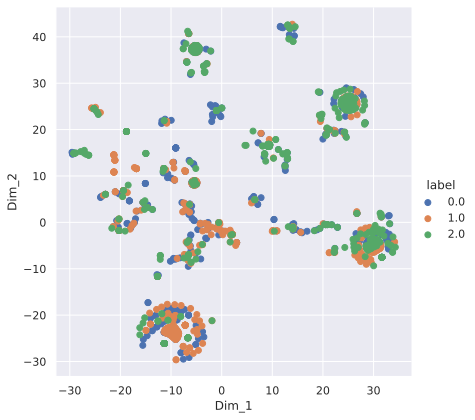

In [81]:
data_1000 = g_feat
labels_1000 = labels
 
model = TSNE(n_components = 2, random_state = 0)
# configuring the parameters
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations
# for the optimization = 1000
 
tsne_data = model.fit_transform(data_1000)
 
# creating a new data frame which
# help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data = tsne_data,
     columns =("Dim_1", "Dim_2", "label"))
 
# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue ="label", size = 6).map(
       plt.scatter, 'Dim_1', 'Dim_2').add_legend()
 
plt.show()